<a href="https://colab.research.google.com/github/ido747/Israel_Football_DB_Stats/blob/main/ligat_haal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install -y chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.2/467.2 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.9 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,081 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-driv

In [ ]:
# Set up the ChromeDriver and import libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Set up options for the ChromeDriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')  # Run Chrome in headless mode (no GUI)
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('executable_path=/usr/bin/chromedriver')



In [ ]:
wd = webdriver.Chrome(options=chrome_options)
url = "https://www.football.co.il/en/stats/" # The website with all the data i want to scrapp
wd.get(url)

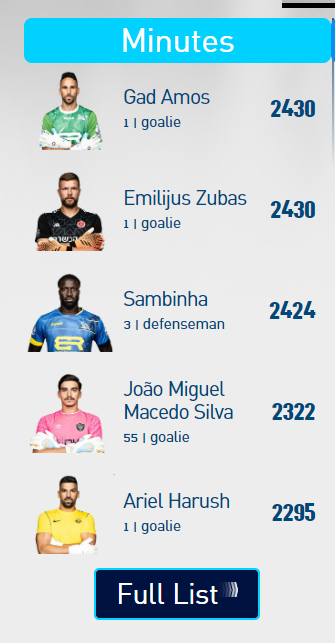

In [ ]:
# Function to load all players for a specific group. in each statistic criteria in the website, at first you only see the top of the players and to see all the players, the user need to press "Full list"
def load_all_players_for_group(group_class_partial):
    # Wait for the "Full List" button for the specified group to be present
    button_locator = (By.XPATH, f'//button[contains(@class, "{group_class_partial}")]')
    WebDriverWait(wd, 10).until(EC.presence_of_element_located(button_locator))

    # Click the "Full List" button for the specified group
    wd.find_element(*button_locator).click()

    # Wait for the additional players to be loaded
    WebDriverWait(wd, 10).until(EC.invisibility_of_element_located((By.CLASS_NAME, "loading-spinner")))


In [ ]:
# The function get the position of the player from the text
def get_position(text):
  if text =="" or len(text)==0:
    return "None"
  else:
    return text.split(" ")[2]

In [ ]:
# The function get the id_name from the javascript code and the metric name and create a df from it.
def create_df(id_name, metric):
    df = pd.DataFrame()
    group_element = wd.find_element(By.ID, id_name)
    player_name_elements = group_element.find_elements(By.CLASS_NAME, "player-list-player-name")
    player_names = [element.text for element in player_name_elements]
    player_metric_elements = group_element.find_elements(By.CLASS_NAME, "player-list-player-count")
    player_metric = [element.text for element in player_metric_elements]
    player_position_elements = group_element.find_elements(By.CLASS_NAME, "player-list-player-role")
    player_position = [get_position(element.text) for element in player_position_elements]
    df['name'] = player_names
    df['position'] = player_position
    df[metric] = player_metric
    return df





In [ ]:
# find the percent of succsess metric out of the total. for example - accurate passes from all passes attepmets.
def find_percent(succ_metric,total_metric,df):
  acc_metric = []
  for s_metric,t_metric in zip(df[succ_metric],df[total_metric]):
    if t_metric ==0:
      acc_metric.append(0)
    else:
      acc_metric.append(s_metric/t_metric)
  return acc_metric


In [ ]:
def metric_per90(metric, num,df):
  metric_res = []
  for metric,minutes in zip(df[metric],df['minutes']):
    if minutes ==0:
      metric_res.append(0)
    else:
      value_per90 = (90*metric)/minutes
      metric_res.append(value_per90)
  return metric_res


In [ ]:
def find_ranking_player(name,df):
   df_filtered = df[df['name'] == name]
   df_rank = df_filtered.rank(method='min', ascending=False)
   return df_rank

In [ ]:
load_all_players_for_group("full-list-totalMinutesPlayed")
load_all_players_for_group("full-list-GoalRegular")
load_all_players_for_group("full-list-Assist")
load_all_players_for_group("full-list-AttemptonGoal")
load_all_players_for_group("full-list-OnTarget")
load_all_players_for_group("full-list-ShotInsidetheArea")
load_all_players_for_group("full-list-ShotOutsidetheArea")
load_all_players_for_group("full-list-Cross")



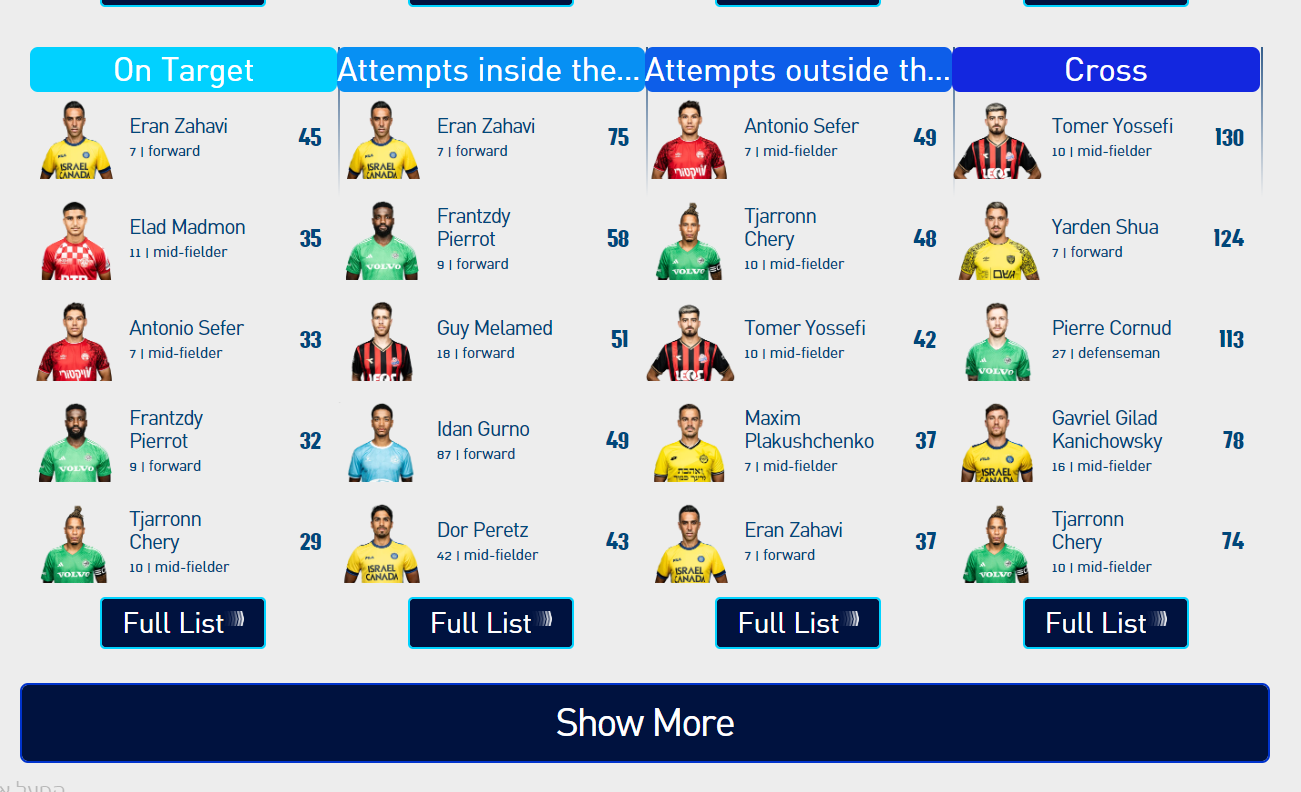

In [ ]:
## At first, the page not show the all stats, and to see all of it, the user need to press "Show More". The following code do it with selenium
from selenium.common.exceptions import NoSuchElementException, TimeoutException
while True:
    try:
        show_more_button_locator = (By.CLASS_NAME, 'stats-see-more-btn')
        WebDriverWait(wd, 20).until(EC.presence_of_element_located(show_more_button_locator))

        # Debug: Print a message when the button is found
        print("Found the 'Show More' button.")

        wd.find_element(*show_more_button_locator).click()

        # Wait for the additional players to be loaded
        WebDriverWait(wd, 20).until(EC.invisibility_of_element_located((By.CLASS_NAME, "loading-spinner")))
    except (NoSuchElementException, TimeoutException):
        # Debug: Print a message when an exception is caught
        print("Exception caught. 'Show More' button not found or timeout occurred.")
        # Break the loop when the "Show More" button is no longer present or timeout occurs
        break


Found the 'Show More' button.
Found the 'Show More' button.
Found the 'Show More' button.
Exception caught. 'Show More' button not found or timeout occurred.


In [ ]:
load_all_players_for_group("full-list-passes")
load_all_players_for_group("full-list-accuratePasses")
load_all_players_for_group("full-list-dribble")
load_all_players_for_group("full-list-wonDribble")
load_all_players_for_group("full-list-tackles")
load_all_players_for_group("full-list-tacklesSuccess")

In [ ]:

load_all_players_for_group("full-list-blockedShot")
load_all_players_for_group("full-list-YellowCard")
load_all_players_for_group("full-list-RedCard")
load_all_players_for_group("full-list-foul")
load_all_players_for_group("full-list-opponentFoul")
load_all_players_for_group("full-list-Offside")
load_all_players_for_group("full-list-appearances")
load_all_players_for_group("full-list-SubOut")
load_all_players_for_group("full-list-SubIn")


In [ ]:
df_minutes = create_df("playerListtotalMinutesPlayed", "minutes")
df_goals = create_df("playerListGoalRegular", "goals")
df_goals

,name,position,goals
0,Eran Zahavi,forward,15
1,Frantzdy Pierrot,forward,14
2,Guy Melamed,forward,12
3,Elad Madmon,mid-fielder,11
4,Din David,forward,11
...,...,...,...
442,Ibrahim Tanko,forward,0
443,Leo Benbenisti,defenseman,0
444,Martin Nazdi,mid-fielder,0
445,Henry Addo,mid-fielder,0


In [ ]:
df_assists = create_df("playerListAssist", "assists")
df_attempt_on_goal = create_df("playerListAttemptonGoal", "attempt_on_goal")
df_ontarget = create_df("playerListOnTarget", "ontarget")
df_inside_area = create_df("playerListShotInsidetheArea", "inside_area")
df_outside_area = create_df("playerListShotOutsidetheArea", "outside_area")
df_passes = create_df("playerListpasses", "passes")
df_acc_passes = create_df("playerListaccuratePasses", "acc_passes")
df_dribbles = create_df("playerListdribble", "dribbles")
df_won_dribbles = create_df("playerListwonDribble", "won_dribbles")
df_tackles = create_df("playerListtackles", "tackles")
df_succ_tackles = create_df("playerListtacklesSuccess", "succ_tackles")
df_crosses = create_df("playerListCross", "crosses")
df_blocked_shots = create_df("playerListblockedShot", "blocked_shots")
df_yellow_cards = create_df("playerListYellowCard", "yellow_cards")
df_red_cards = create_df("playerListRedCard", "red_cards")
df_fouls = create_df("playerListfoul", "fouls")





In [ ]:
df_opponent_fouls = create_df("playerListopponentFoul", "opponent_foul")
df_offside = create_df("playerListOffside", "offside")
df_appearances = create_df("playerListappearances", "appearances")
df_sub_out = create_df("playerListSubOut", "sub_out")
df_sub_in = create_df("playerListSubIn", "sub_in")

In [ ]:
# merge all the df to one big DB that include all the data for each player.
df_total = pd.merge(df_minutes, df_goals, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_assists, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_attempt_on_goal, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_ontarget, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_inside_area, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_outside_area, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_passes, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_acc_passes,on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_dribbles, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_won_dribbles, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_tackles, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_succ_tackles, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_crosses, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_blocked_shots, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_yellow_cards, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_red_cards,on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_fouls, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_opponent_fouls, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_offside, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_appearances, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_sub_out, on=['name','position'], how='outer')
df_total = pd.merge(df_total, df_sub_in, on=['name','position'], how='outer')
df_total.iloc[:, 2:] = df_total.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')


In [ ]:
#remove duplicates and convert the db to a csv file
df_no_duplicates = df_total.drop_duplicates()
df_no_duplicates.to_csv("Total_DB_stats.csv",index=False)
df_total = df_no_duplicates


In [ ]:
# Close the web driver
wd.quit()

In [ ]:
#creating new metrics that based on perecentages.
df_total['acc_pass_per'] = find_percent("acc_passes","passes",df_total)
df_total['acc_tackles_per'] = find_percent("succ_tackles","tackles",df_total)
df_total['acc_dribble_per'] = find_percent("won_dribbles","dribbles",df_total)
df_total['acc_shot_target_per'] = find_percent("ontarget","attempt_on_goal",df_total)
df_total['goal_per_shot'] = find_percent("goals","attempt_on_goal",df_total)


In [ ]:
df_total

,name,position,minutes,goals,assists,attempt_on_goal,ontarget,inside_area,outside_area,passes,...,opponent_foul,offside,appearances,sub_out,sub_in,acc_pass_per,acc_tackles_per,acc_dribble_per,acc_shot_target_per,goal_per_shot
0,Gad Amos,goalie,2430,0,0,0,0,0,0,800,...,2,0,27,0,0,0.648750,0.000000,0.0,0.0,0.0
1,Emilijus Zubas,goalie,2430,0,0,0,0,0,0,723,...,1,0,27,0,0,0.676349,0.000000,0.0,0.0,0.0
2,Sambinha,defenseman,2424,2,1,10,3,10,0,1215,...,22,0,27,0,0,0.835391,0.714286,0.5,0.3,0.2
3,João Miguel Macedo Silva,goalie,2322,0,1,0,0,0,0,895,...,1,0,26,1,0,0.730726,0.000000,0.0,0.0,0.0
4,Ariel Harush,goalie,2295,0,0,0,0,0,0,652,...,2,0,26,1,0,0.601227,0.000000,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,Roy Ben Navi,None,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0
443,Yarin Hanoum,None,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0
444,Noam Shachar,forward,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0
445,Hamza Merey,None,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0


In [ ]:
def top_n(df,metric,num):
  df_filtered = df.sort_values(by=metric, ascending=False).head(num)
  return df_filtered[['name',metric]]

In [ ]:
#only for shoots, passes, dribbles and tackles
def top_n_percent(df,metric,num,threshold):
  filtered_players = df[df['minutes'] > 0]
  filtered_players = filtered_players[filtered_players[metric] >= threshold]

  accurate_percent = ""
  if metric =="passes":
    accurate_percent = 'accurate_passes_percent'
    filtered_players[accurate_percent] = filtered_players['acc_passes']/filtered_players['passes']

  elif metric =="tackles":
    accurate_percent = 'accurate_tackles_percent'
    filtered_players[accurate_percent] = filtered_players['succ_tackles']/filtered_players['tackles']

  elif metric =="dribbles":
    accurate_percent = 'accurate_dribbles_percent'
    filtered_players[accurate_percent] = filtered_players['won_dribbles']/filtered_players['dribbles']

  elif metric =="attempt_on_goal":
    accurate_percent = 'shoots_on_target_percent'
    filtered_players[accurate_percent] = filtered_players['ontarget']/filtered_players['attempt_on_goal']

  df_filtered = filtered_players.sort_values(by=accurate_percent, ascending=False).head(num)
  return df_filtered[['name',accurate_percent,metric]]

In [ ]:
import numpy as np

def top_n_per90(df,metric,num,threshold_minutes):
  filtered_players = df[df['minutes'] >= threshold_minutes]
  value_per90 = metric+'_per_90'
  filtered_players[value_per90] = np.where(filtered_players['minutes'] == 0,
                                             0,
                                             filtered_players[metric] * 90 / filtered_players['minutes'])
  df_filtered = filtered_players.sort_values(by=value_per90, ascending=False).head(num)
  return df_filtered[['name',value_per90]]

In [ ]:
def minutes_to_metric(df,metric,num,threshold_minutes):
  filtered_players = df[df['minutes'] >= threshold_minutes]
  filtered_players = filtered_players[filtered_players[metric] >0]

  minutes_to_metric = 'minutes to '+metric
  filtered_players = filtered_players[filtered_players['minutes']>0]
  filtered_players[minutes_to_metric] = filtered_players['minutes']/ filtered_players[metric]
  df_filtered = filtered_players.sort_values(by=minutes_to_metric, ascending=True).head(num)
  return df_filtered[['name',minutes_to_metric]]





In [ ]:
def conversion_rate_shoot_to_goal(df,num,threshold):
  filtered_players = df[(df['attempt_on_goal'] >= threshold) & (df['attempt_on_goal'] >0)]

  filtered_players['conversion_rate'] = filtered_players['goals']/filtered_players['attempt_on_goal']
  df_filtered = filtered_players.sort_values(by='conversion_rate', ascending=False).head(num)
  return df_filtered[['name','conversion_rate','goals']]



In [ ]:
def conversion_rate_target_shoot_to_goal(df,num,threshold):
    filtered_players = df[df['attempt_on_goal'] >= threshold]
    filtered_players['conversion_rate'] = filtered_players['goals']/filtered_players['ontarget']
    df_filtered = filtered_players.sort_values(by='conversion_rate', ascending=False).head(num)
    return df_filtered[['name','conversion_rate','goals']]


In [ ]:
top_n(df_total,"goals",15)

,name,goals
25,Eran Zahavi,15
105,Frantzdy Pierrot,14
52,Guy Melamed,12
37,Elad Madmon,11
148,Din David,11
6,Tomer Yossefi,10
9,Yarden Shua,10
134,Rotem Hatuel,8
143,Dor Turgeman,7
48,Shlomi Azulay,7


In [ ]:
top_n(df_total,"dribbles",15)

,name,dribbles
88,Felicio Mendes Joao Milson,133
22,Anan Khalaili,124
29,Hisham Layous,114
47,Zahi Ahmed,113
70,Mohammed Kamara,101
50,Freddy Enrique Vargas Piñero,101
37,Elad Madmon,97
9,Yarden Shua,86
6,Tomer Yossefi,82
35,Idan Gurno,80


In [ ]:
# top_n_percent(df_total,"passes",15,300)
# top_n_percent(df_total,"tackles",15,35)
top_n_percent(df_total,"dribbles",15,70)
# top_n_percent(df_total,"attempt_on_goal",15,30)

,name,accurate_dribbles_percent,dribbles
6,Tomer Yossefi,0.609756,82
70,Mohammed Kamara,0.594059,101
88,Felicio Mendes Joao Milson,0.548872,133
50,Freddy Enrique Vargas Piñero,0.534653,101
29,Hisham Layous,0.526316,114
47,Zahi Ahmed,0.513274,113
136,Amir Chaim Ganah,0.506667,75
22,Anan Khalaili,0.5,124
9,Yarden Shua,0.465116,86
102,Itay Buganim,0.464789,71


In [ ]:
# top_n_per90(df_total,"goals",10,300)
# top_n_per90(df_total,"assists",10,300)
# top_n_per90(df_total,"fouls",10,300)
top_n_per90(df_total,"offside",10,300)

<ipython-input-58-f648381fc3ba>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_players[value_per90] = np.where(filtered_players['minutes'] == 0,


,name,offside_per_90
233,Itay Shechter,1.857143
203,Ben Sahar,1.48855
198,Ezekiel Henty,1.440887
189,Itamar Shabiro,1.232877
127,Kayes Ganem,1.213483
216,Osvaldo Pedro Capemba,1.128134
105,Frantzdy Pierrot,1.121107
88,Felicio Mendes Joao Milson,1.051948
134,Rotem Hatuel,0.987461
125,Muhamad Shaker,0.940299


In [ ]:
# minutes_to_metric(df_total,"goals",10,500)
# minutes_to_metric(df_total,"acc_passes",10,500)
minutes_to_metric(df_total,"yellow_cards",10,500)



,name,minutes to yellow_cards
254,Ihab Ganaem,104.6
233,Itay Shechter,126.0
186,Naftali Balay,148.833333
241,Aviel Yosef Zargary,151.25
238,Nadav Aviv Niddam,152.75
111,Karem Jaber,157.111111
133,Mavis Tchibota,162.25
144,Shay Elias,173.714286
247,Anas Mahamid,182.333333
182,Jose Rodriguez,183.4


In [ ]:
conversion_rate_shoot_to_goal(df_total,15,30)

<ipython-input-69-53068705e6b0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_players['conversion_rate'] = filtered_players['goals']/filtered_players['attempt_on_goal']


,name,conversion_rate,goals
105,Frantzdy Pierrot,0.233333,14
48,Shlomi Azulay,0.21875,7
148,Din David,0.215686,11
52,Guy Melamed,0.20339,12
134,Rotem Hatuel,0.2,8
9,Yarden Shua,0.2,10
175,Alon Turgeman,0.193548,6
88,Felicio Mendes Joao Milson,0.176471,6
72,Lior Refaelov,0.175,7
10,Hélder Lopes,0.166667,5


In [ ]:
conversion_rate_target_shoot_to_goal(df_total,15,30)

<ipython-input-28-b005a3437516>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_players['conversion_rate'] = filtered_players['goals']/filtered_players['ontarget']


,name,conversion_rate,goals
134,Rotem Hatuel,0.615385,8
10,Hélder Lopes,0.555556,5
9,Yarden Shua,0.526316,10
141,Omri Altman,0.5,4
72,Lior Refaelov,0.5,7
66,Cédric Franck Don,0.5,3
52,Guy Melamed,0.5,12
48,Shlomi Azulay,0.466667,7
88,Felicio Mendes Joao Milson,0.461538,6
148,Din David,0.458333,11


**RANKS**

In [ ]:
# rank_df = pd.DataFrame(df_total['name'])
# for col in df_total.columns[2:]:
#     rank_df[col] = df_total[col].rank(ascending=False)

**GRAPHS**

In [ ]:
!pip install seaborn matplotlib



Successful dribble percent and Successful passing percent

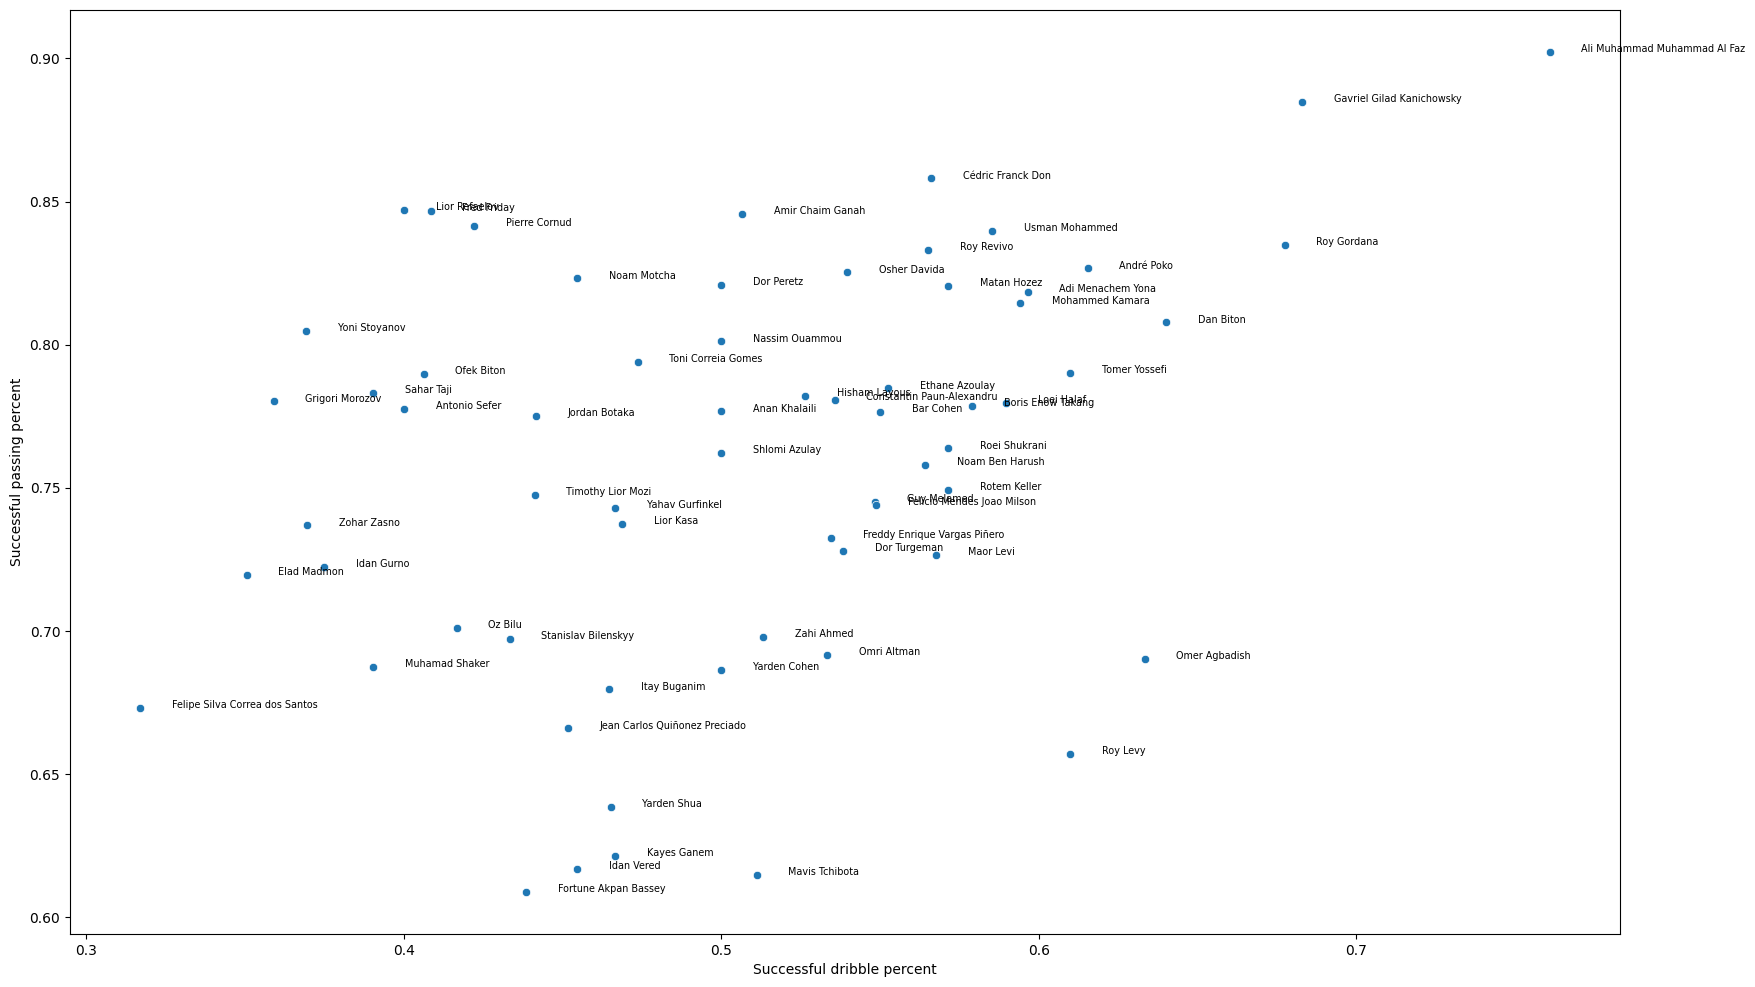

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Apply filtering conditions to create df_filtered_graph
df_filtered_graph = df_total[(df_total['passes'] >= 200) & (df_total['dribbles'] >= 30)]

# Check if df_filtered_graph is not empty
if not df_filtered_graph.empty:
    # Sample data
    data = {
        'X': df_filtered_graph['acc_dribble_per'],
        'Y': df_filtered_graph['acc_pass_per'],
        'Name': df_filtered_graph['name']
    }

    df = pd.DataFrame(data)

    plt.figure(figsize=(20, 12))

    sns.scatterplot(x='X', y='Y', data=df)

    for line in range(0, df.shape[0]):
        plt.text(df['X'].iloc[line] + 0.01, df['Y'].iloc[line], df['Name'].iloc[line],
                 horizontalalignment='left', size='x-small', color='black')

    plt.xlabel('Successful dribble percent')
    plt.ylabel('Successful passing percent')
    plt.show()
else:
    print("No data to plot after filtering.")


Successful tackles percent and Successful passing percent

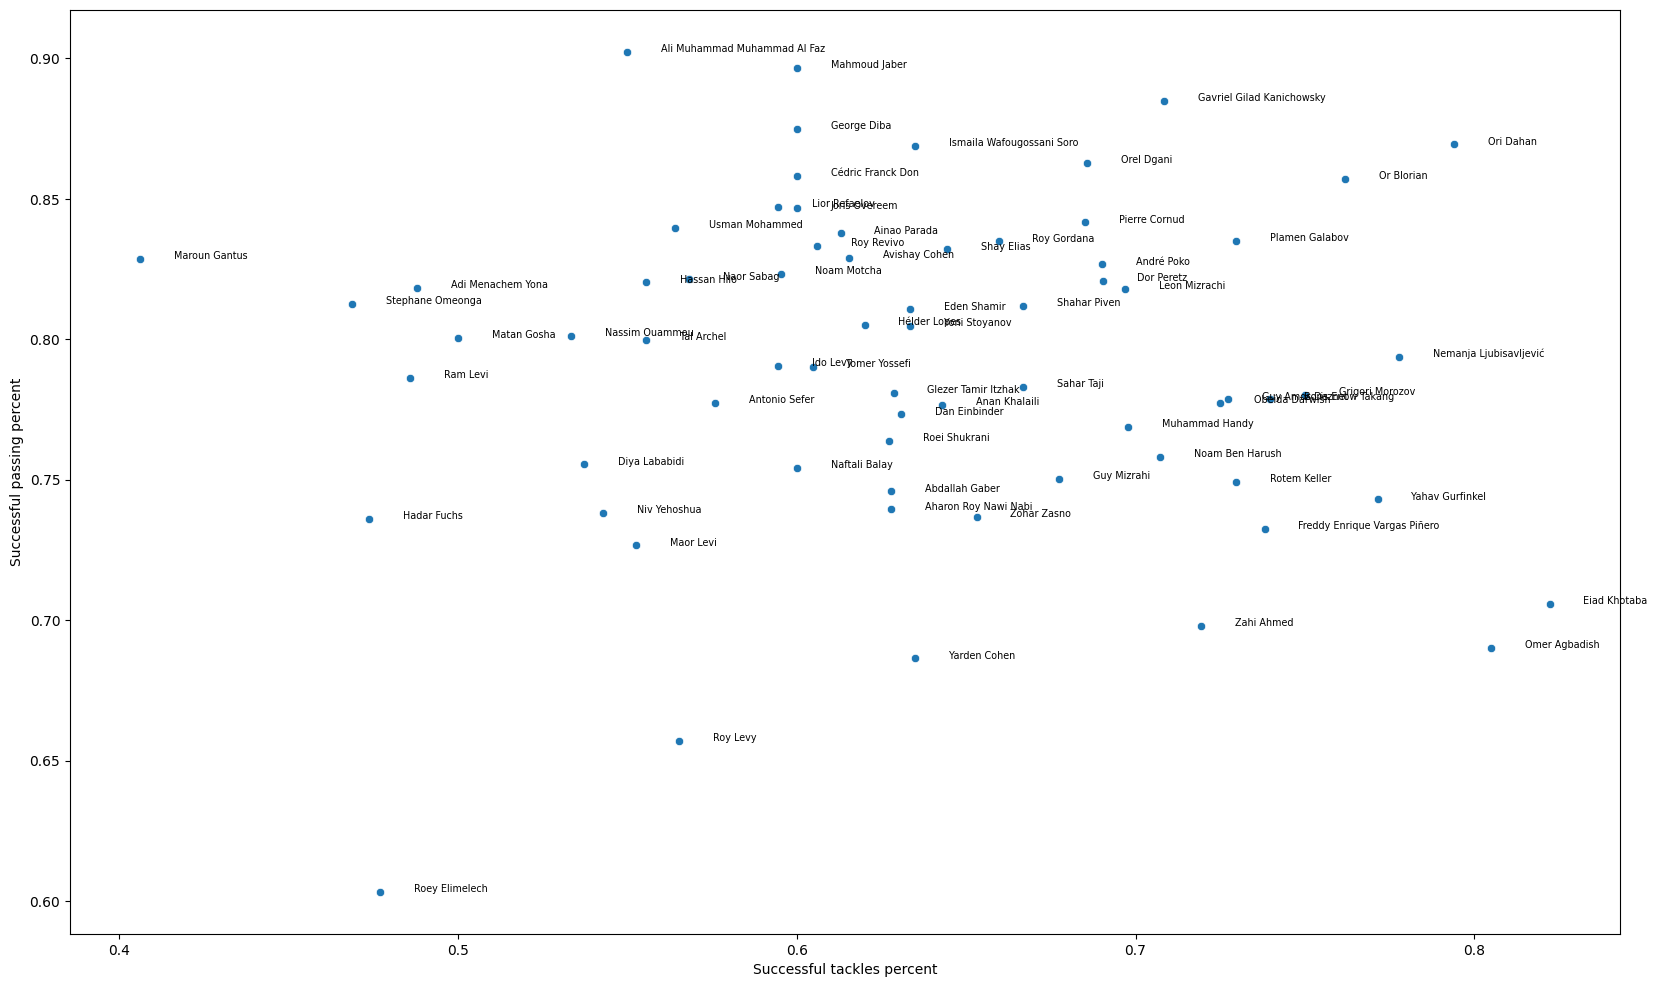

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Apply filtering conditions to create df_filtered_graph
df_filtered_graph_10 = df_total[(df_total['passes'] >= 500) & (df_total['tackles'] >= 30)]

# Check if df_filtered_graph is not empty
if not df_filtered_graph_10.empty:
    # Sample data
    data = {
        'X': df_filtered_graph_10['acc_tackles_per'],
        'Y': df_filtered_graph_10['acc_pass_per'],
        'Name': df_filtered_graph_10['name']
    }

    df = pd.DataFrame(data)

    plt.figure(figsize=(20, 12))

    sns.scatterplot(x='X', y='Y', data=df)

    for line in range(0, df.shape[0]):
        plt.text(df['X'].iloc[line] + 0.01, df['Y'].iloc[line], df['Name'].iloc[line],
                 horizontalalignment='left', size='x-small', color='black')

    plt.xlabel('Successful tackles percent')
    plt.ylabel('Successful passing percent')
    plt.show()
else:
    print("No data to plot after filtering.")

attempt on goal and Successful dribble percent

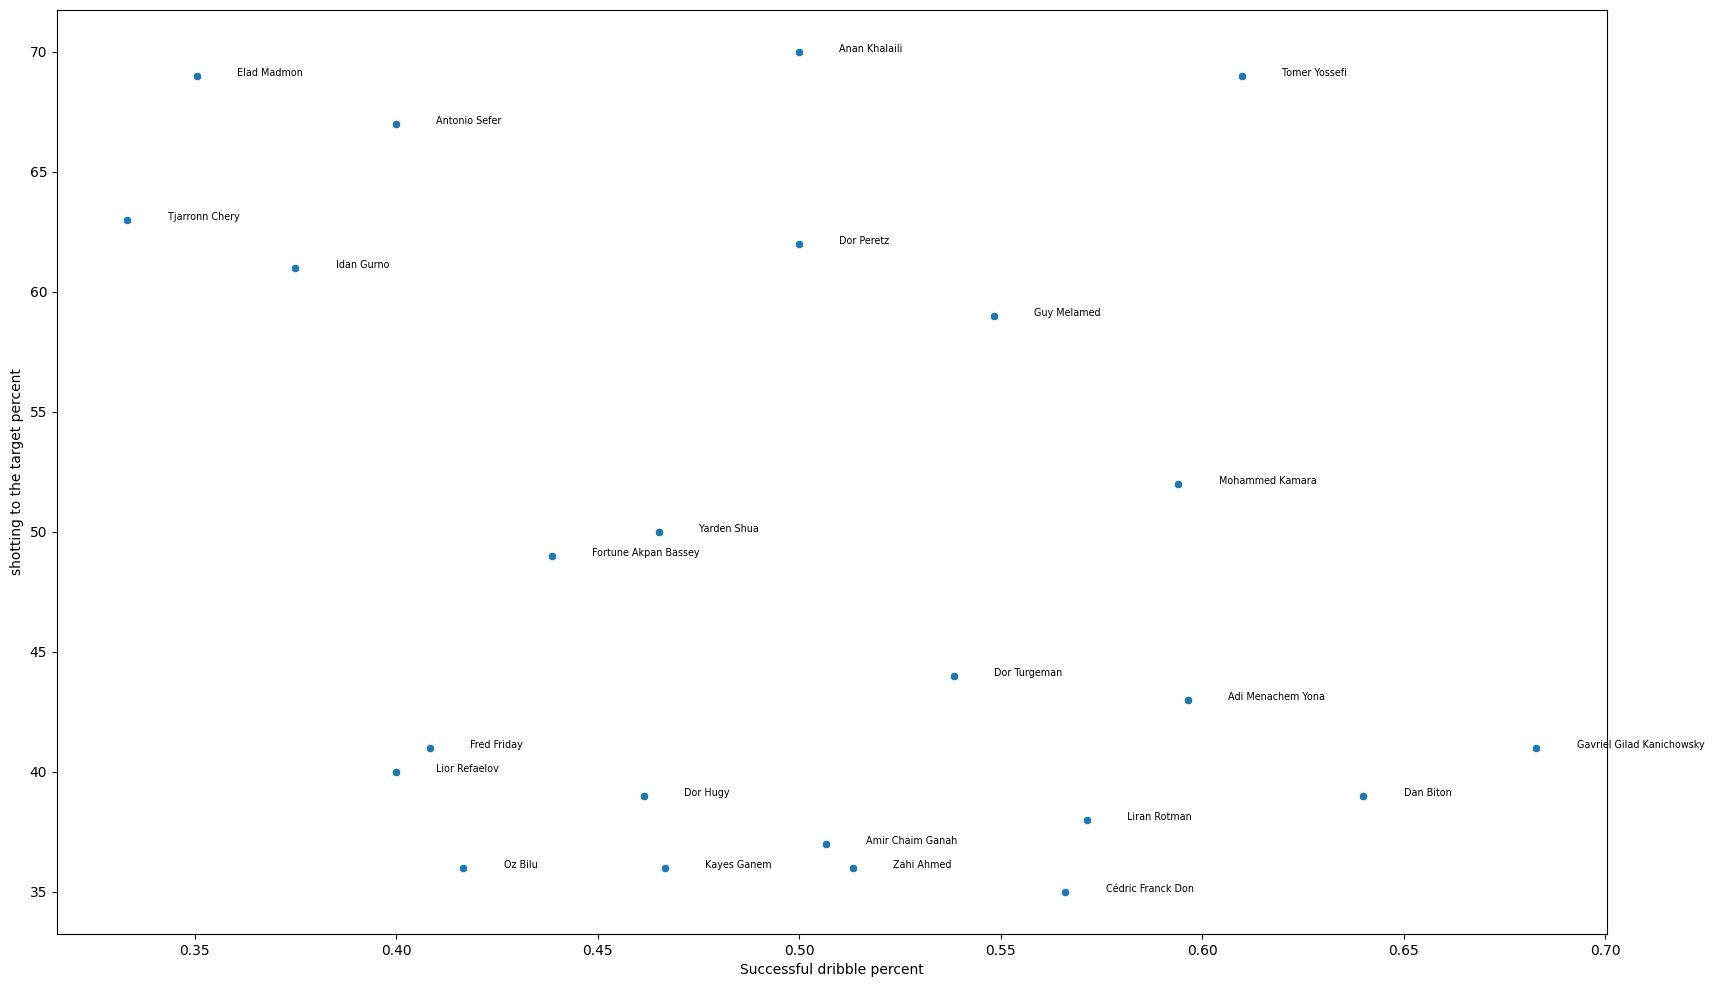

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mplcursors


df_filtered_graph_2 = df_total[(df_total['attempt_on_goal'] >= 35) & (df_total['dribbles'] >= 25)]

if not df_filtered_graph.empty:
    data = {
        'X': df_filtered_graph_2['acc_dribble_per'],
        'Y': df_filtered_graph_2['attempt_on_goal'],
        'Name': df_filtered_graph_2['name']
    }

    df = pd.DataFrame(data)

    plt.figure(figsize=(20, 12))

    sns.scatterplot(x='X', y='Y', data=df)

    for line in range(0, df.shape[0]):
        plt.text(df['X'].iloc[line] + 0.01, df['Y'].iloc[line], df['Name'].iloc[line],
                 horizontalalignment='left', size='x-small', color='black')

    plt.xlabel('Successful dribble percent')
    plt.ylabel('shotting to the target percent')
    plt.show()
else:
    print("No data to plot after filtering.")


 **move the data to google sheet and after that to Looker Studio**

In [ ]:

import pandas as pd
import gspread
from gspread_dataframe import set_with_dataframe
from google.oauth2.service_account import Credentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
scopes = ['https://www.googleapis.com/auth/spreadsheets',
          'https://www.googleapis.com/auth/drive']

credentials = Credentials.from_service_account_file('/content/football-412915-5d5a8a9052c1.json', scopes=scopes) ## need to import the json file. right now it only with me.

gc = gspread.authorize(credentials)

gauth = GoogleAuth()
drive = GoogleDrive(gauth)

# open a google sheet
gs = gc.open_by_key("KEY") # the authentication key from google. right now it only with me.
# select a work sheet from its name
worksheet1 = gs.worksheet('player_data')



In [ ]:
worksheet1.clear()
set_with_dataframe(worksheet=worksheet1, dataframe=df_total, include_index=False,
include_column_header=True, resize=True)

In [123]:
# !git clone <https://github.com/ido747/Israel_Football_DB_Stats.git>


/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `git clone <https://github.com/ido747/Israel_Football_DB_Stats.git>'
